## **Construct Training Target for Flow Matching and Generative Models**

This notebook shows how the vector field $u_t^{\text{target}}(x \mid z)$ generates trajectories that match the conditional Gaussian path $p_t(x \mid z)$

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline 

### **2. Define the Conditional Gaussian Path**

We need to define $\alpha_t$ and $\beta_t$, which control the mean and variance of the Gaussian path $p_t(x \mid z)$.

At $t = 0$,  $p_0(x \mid z) = \mathcal{N}(0, I_d)$,  so $\alpha_0 = 0$, $\beta_0 = 1$.

At $t = 1$,  $p_1(x \mid z) = \mathcal{N}(\alpha z, \beta^2 I_d)$.  
Let’s choose $\alpha = 2$, $\beta = 0.5$ for the final distribution.

For simplicity, assume $\alpha_t$ and $\beta_t$ vary linearly with time:

- $\alpha_t = \alpha t$
- $\beta_t = 1 + (\beta - 1)t$

So:

- $\alpha_0 = 0$, $\alpha_1 = \alpha$
- $\beta_0 = 1$, $\beta_1 = \beta$

We also need their derivatives:

- $\dot{\alpha}_t = \frac{d}{dt}(\alpha t) = \alpha$
- $\dot{\beta}_t = \frac{d}{dt}(1 + (\beta - 1)t) = \beta - 1$


In [2]:
# Parameters 
alpha = 2.0 # Final mean coefficient at t= 1
beta = 0.5 # Final standard derivation at t = 1
d = 2 #2D space for visualization

# DEfine alpha_t and beta_t
def alpha_t(t): 
    return alpha * t

def beta_t(t): 
    return 1 + (beta -1) * t

# Derivatives
def alpha_dot_t(t): 
    return alpha

def beta_dot_t(t): 
    return beta - 1

### **3. Define the Vector Field**

The vector field from Example 11 is:

$$
u_t^{\text{target}}(x \mid z) = \left( {\dot{\alpha}_t - \frac{\dot{\beta}_t}{\beta_t} \alpha_t}{ } \right) z + \frac{\dot{\beta}_t}{\beta_t} x
$$


In [3]:
def u_t_target(x, z, t):
    at = alpha_t(t)
    bt = beta_t(t)
    adt = alpha_dot_t(t)
    bdt = beta_dot_t(t)
    term1 = (adt - (bdt / bt) * at) *z
    term2 = (bdt/bt) * x
    return term1 + term2

### **4. Simulate ODE Trajectories Using Euler’s Method**

We’ll use the Euler method (similar to Algorithm 1) to simulate the ODE trajectories.  
We start with:

$$
X_0 \sim \mathcal{N}(0, I_d)
$$

We condition on a fixed $z$, and compute $X_t$ over time.

**Parameters:**

- $z = [1, 1]$ (a fixed conditioning vector)  
- $n_{\text{steps}} = 100$

Simulate multiple trajectories to observe the resulting distribution.


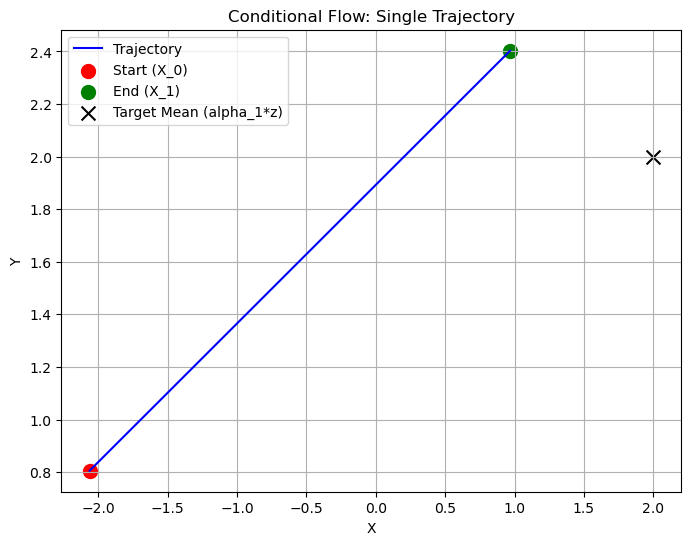

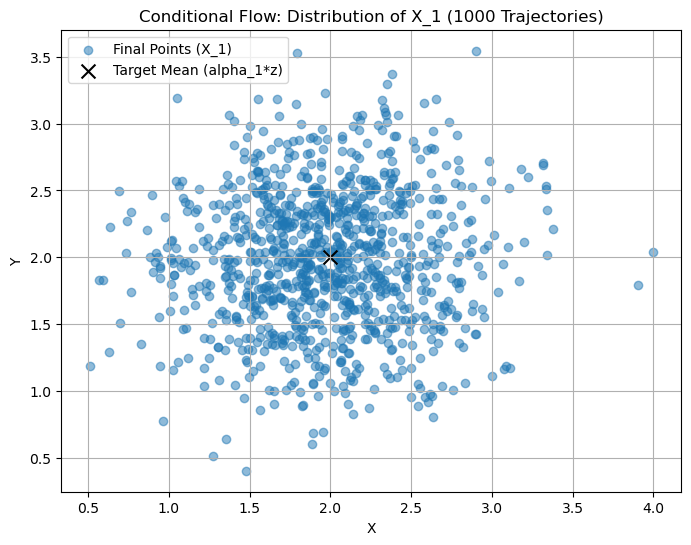

Mean of X_1: [1.96801767 1.98093306]
Theoretical mean (alpha_1*z): [2. 2.]
Variance of X_1: [0.25656374 0.26666467]
Theoretical variance (beta_1^2): 0.25


In [4]:
# Simulation parameters
z = np.array([1.0, 1.0])  # Conditioning vector
n_steps = 100
h = 1.0 / n_steps
n_trajectories = 1000

# Initial distribution: Sample X_0 from N(0, I_d)
X_0 = np.random.randn(2)  # Single trajectory for visualization

# Simulate a single trajectory
t = 0.0
X_t = X_0.copy()
trajectory = [X_t]

for i in range(n_steps):
    X_t = X_t + h * u_t_target(X_t, z, t)
    t += h
    trajectory.append(X_t.copy())

trajectory = np.array(trajectory)

# Plot the single trajectory
plt.figure(figsize=(8, 6))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'b-', label='Trajectory')
plt.scatter(trajectory[0, 0], trajectory[0, 1], c='red', label='Start (X_0)', s=100)
plt.scatter(trajectory[-1, 0], trajectory[-1, 1], c='green', label='End (X_1)', s=100)
plt.scatter([alpha_t(1) * z[0]], [alpha_t(1) * z[1]], c='black', label='Target Mean (alpha_1*z)', s=100, marker='x')
plt.title('Conditional Flow: Single Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# Simulate multiple trajectories to see the distribution
final_points = []

for _ in range(n_trajectories):
    X_t = np.random.randn(2)  # Sample a new X_0 for each trajectory
    t = 0.0
    for i in range(n_steps):
        X_t = X_t + h * u_t_target(X_t, z, t)
        t += h
    final_points.append(X_t)

final_points = np.array(final_points)

# Plot the distribution at t=1
plt.figure(figsize=(8, 6))
plt.scatter(final_points[:, 0], final_points[:, 1], alpha=0.5, label='Final Points (X_1)')
plt.scatter([alpha_t(1) * z[0]], [alpha_t(1) * z[1]], c='black', label='Target Mean (alpha_1*z)', s=100, marker='x')
plt.title('Conditional Flow: Distribution of X_1 (1000 Trajectories)')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

# Compute mean and variance
mean_final = np.mean(final_points, axis=0)
var_final = np.var(final_points, axis=0)
print(f"Mean of X_1: {mean_final}")
print(f"Theoretical mean (alpha_1*z): {alpha_t(1) * z}")
print(f"Variance of X_1: {var_final}")
print(f"Theoretical variance (beta_1^2): {beta_t(1)**2}")

### **5. Visualize the Distribution at Intermediate Times**

To see how the distribution evolves over time, let's simulate the distribution at t=0, t=0.5, and t=1

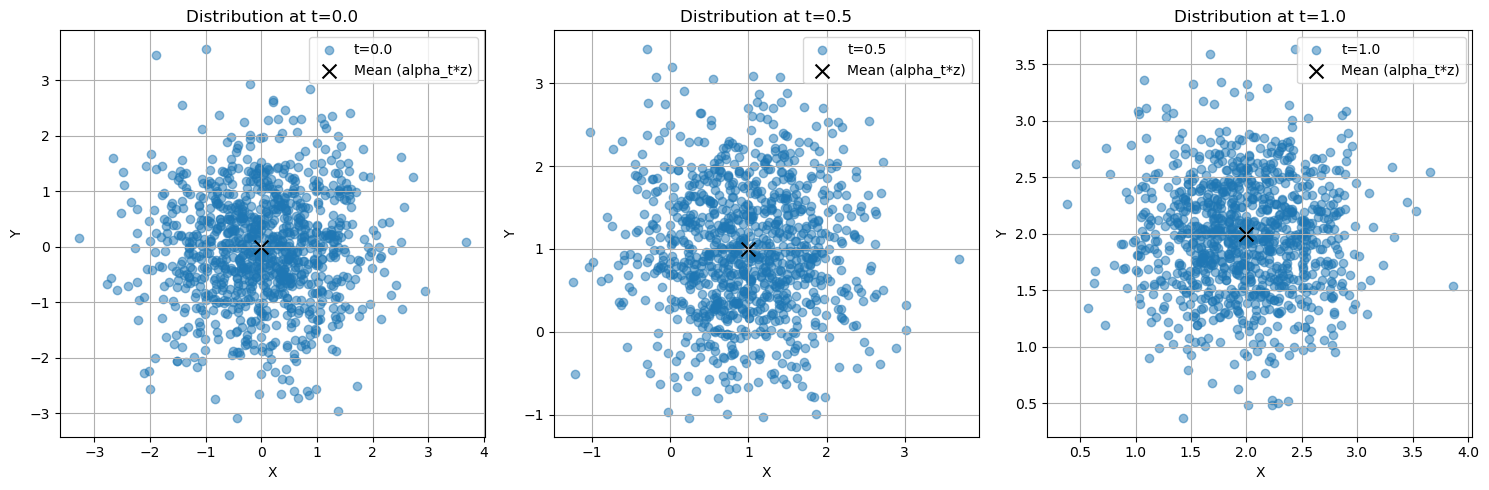

In [5]:
# Simulate distributions at different times
times = [0.0, 0.5, 1.0]
distributions = []

for t_target in times:
    points = []
    for _ in range(n_trajectories):
        X_t = np.random.randn(2)
        t = 0.0
        for i in range(int(t_target * n_steps)):
            X_t = X_t + h * u_t_target(X_t, z, t)
            t += h
        points.append(X_t)
    distributions.append(np.array(points))

# Plot distributions
plt.figure(figsize=(15, 5))
for i, t in enumerate(times):
    plt.subplot(1, 3, i+1)
    points = distributions[i]
    plt.scatter(points[:, 0], points[:, 1], alpha=0.5, label=f't={t}')
    plt.scatter([alpha_t(t) * z[0]], [alpha_t(t) * z[1]], c='black', label='Mean (alpha_t*z)', s=100, marker='x')
    plt.title(f'Distribution at t={t}')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
plt.tight_layout()
plt.show()

The trajectories move from the initial noise distribution toward a mean determined by z. The distribution at t= 1 matches $\mathcal{N}(\alpha z, \beta^2 I_d)$ with the correct mean and variance. 